In [81]:
%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import PorterStemmer
import string
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import log_loss
from scipy.sparse import lil_matrix

from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix


In [72]:
#import data
sms_data = pd.read_csv('/Users/nataliya/Desktop/SMSSpamCollection.csv', delimiter=';',  error_bad_lines=False)

sms_data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [73]:
sms_data.columns = ['label', 'message', 'drop1', 'drop2', 'drop3']
sms_data.tail(10)

,label,message,drop1,drop2,drop3
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...,NaN,NaN,NaN
5563,ham,Ard 6 like dat lor.,NaN,NaN,NaN
5564,ham,Why don't you wait 'til at least wednesday to ...,NaN,NaN,NaN
5565,ham,Huh y lei...,NaN,NaN,NaN
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,NaN,NaN,NaN
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [74]:
#dropping extra columns
sms_data.drop(['drop1', 'drop2','drop3'], axis=1, inplace=True)
sms_data.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


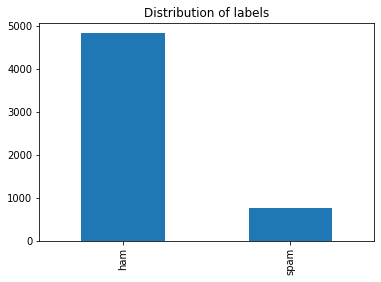

In [7]:
# looking at labels distribution for choosing the metric
x=pd.value_counts(sms_data["label"], sort= True)
x.plot(kind= 'bar')
plt.title('Distribution of labels')
plt.show()

We can see that the sample faces imbalance problem.

I've chosen **precision**  as the main metric due to the fact that false positive spam is worse for users, so our main goal is to classify ham correctly.

In [8]:
#removing punctuation, putting text into lowercase, tokenizing
import nltk
nltk.download('stopwords')

def process_text(text):
    tokenized=re.split('\W+',text)
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    return tokens

sms_data['tokens']=sms_data['message'].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
sms_data.drop(['message'], axis=1, inplace=True)
sms_data.head(10)

,label,tokens
0,ham,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,"[ok, lar, joke, wif, u, oni]"
2,spam,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"[nah, think, goe, usf, live, around, though]"
5,spam,"[freemsg, hey, darl, 3, week, word, back, like..."
6,ham,"[even, brother, like, speak, treat, like, aid,..."
7,ham,"[per, request, mell, mell, oru, minnaminungint..."
8,spam,"[winner, valu, network, custom, select, receiv..."
9,spam,"[mobil, 11, month, u, r, entitl, updat, latest..."


In [10]:
#adding 0/1 column for spam
sms_data['spam']=(sms_data['label'] =='spam').astype(int)
sms_data.head(10)

,label,tokens,spam
0,ham,"[go, jurong, point, crazi, avail, bugi, n, gre...",0
1,ham,"[ok, lar, joke, wif, u, oni]",0
2,spam,"[free, entri, 2, wkli, comp, win, fa, cup, fin...",1
3,ham,"[u, dun, say, earli, hor, u, c, alreadi, say]",0
4,ham,"[nah, think, goe, usf, live, around, though]",0
5,spam,"[freemsg, hey, darl, 3, week, word, back, like...",1
6,ham,"[even, brother, like, speak, treat, like, aid,...",0
7,ham,"[per, request, mell, mell, oru, minnaminungint...",0
8,spam,"[winner, valu, network, custom, select, receiv...",1
9,spam,"[mobil, 11, month, u, r, entitl, updat, latest...",1


In [11]:
#splitting to train and test data
train_data = sms_data.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_data = sms_data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [12]:
sms_data['label'].value_counts() / sms_data.shape[0] * 100

ham     86.593683
spam    13.406317
Name: label, dtype: float64

In [13]:
train_data['label'].value_counts() / train_data.shape[0] * 100

ham     86.40646
spam    13.59354
Name: label, dtype: float64

In [14]:
test_data['label'].value_counts() / test_data.shape[0] * 100

ham     86.983842
spam    13.016158
Name: label, dtype: float64

**Naive Bayes coded by hands**

In [19]:
#creating vocabulary
vocab = list(set(train_data['tokens'].sum()))

In [20]:
#counting separate words in messages
word_counts_per_msg = pd.DataFrame([
    [row[1].count(word) for word in vocab]
    for _, row in train_data.iterrows()], columns=vocab)

In [22]:
#concatenating countings of words with train data
train_data = pd.concat([train_data.reset_index(), word_counts_per_msg], axis=1).iloc[:,1:]

In [24]:
#checking the result
train_data.head()

,label,tokens,spam,drum,decim,exorc,nevil,tomo,well,dabbl,...,artist,coher,ti,hamper,ystrday,bandag,o2,public,convey,bahama
0,ham,"[convey, regard]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,ham,"[û_, anyway, mani, good, even, u]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[sort, code, acc, bank, natwest, repli, confir...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[sorri, din, lock, keypad]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,"[hi, babe, chloe, r, u, smash, saturday, night...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#calculating probabilities of msg being spam or not
prob_spam = train_data['label'].value_counts()['spam'] / train_data.shape[0]
prob_ham = train_data['label'].value_counts()['ham'] / train_data.shape[0]

In [32]:
#counting words in spam/ham msgs
n_spam = train_data.loc[train_data['label'] == 'spam', 'tokens'].apply(len).sum()
n_ham = train_data.loc[train_data['label'] == 'ham', 'tokens'].apply(len).sum()

In [36]:
n_voc = len(train_data.columns) - 3

In [45]:
#setting alpha for Laplacian smoothing
alpha = 1 

In [46]:
#calculating probability of word with spam label
def p_w_spam(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['label'] == 'spam', word].sum() + alpha) / (n_spam + alpha*n_voc)
    else:
        return 1
#calculating probability of word with ham label     
def p_w_ham(word):
    if word in train_data.columns:
        return (train_data.loc[train_data['label'] == 'ham', word].sum() + alpha) / (n_ham + alpha*n_voc)
    else:
        return 1

In [47]:
#classification function

def classify(message):
    p_spam_given_message = prob_spam
    p_ham_given_message = prob_ham
    for word in message:
        p_spam_given_message *= p_w_spam(word)
        p_ham_given_message *= p_w_ham(word)
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'we need some extra classification'

In [48]:
#checking
classify('hi')

'ham'

In [49]:
classify(['i', 'wanna', 'die'])

'ham'

In [50]:
classify(['we', 'offer', 'services'])

'spam'

In [52]:
#applying predictions to our test data
test_data['prediction'] = test_data['tokens'].apply(classify)

In [53]:
test_data.head(10)

,label,tokens,spam,prediction
0,spam,"[welcom, uk, mobil, date, msg, free, give, fre...",1,spam
1,ham,"[wish, great, day, moji, told, offer, alway, s...",0,ham
2,ham,"[thank, repli, today, ur, visa, come, r, u, st...",0,ham
3,ham,"[sorri, flake, last, night, shit, serious, goi...",0,ham
4,ham,"[said, look, pretti, wif, long, hair, wat, thk...",0,ham
5,ham,"[ranjith, cal, drpd, deeraj, deepak, 5min, hold]",0,ham
6,ham,"[cheer, callin, babe, sozi, culdnt, talkbut, w...",0,ham
7,ham,"[hey, u, still, gym]",0,ham
8,ham,"[said, u, mind, go, bedroom, minut, ok, sed, s...",0,ham
9,ham,"[much, better, thank, lol]",0,ham


In [64]:
pred = test_data['tokens'].apply(classify)

In [67]:
#checking the results
print(classification_report(test_data['label'],pred))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       969
        spam       0.96      0.97      0.97       145

    accuracy                           0.99      1114
   macro avg       0.98      0.98      0.98      1114
weighted avg       0.99      0.99      0.99      1114



**Scikit Naive Bayes**

In [76]:
sms2_data = pd.read_csv('/Users/nataliya/Desktop/SMSSpamCollection.csv', delimiter=';',  error_bad_lines=False)
sms2_data.columns = ['label', 'message', 'drop1', 'drop2', 'drop3']
sms2_data.drop(['drop1', 'drop2','drop3'], axis=1, inplace=True)
sms2_data.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [77]:
#defining depending and independing variables
x = sms2_data['message']
y = sms2_data['label']

In [78]:
#splitting into tran/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [82]:
vector = CV()
training_data = vector.fit_transform(X_train.values)
test_data = vector.transform(X_test)

In [84]:
clfr = MultinomialNB()
clfr.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [86]:
prediction = clfr.predict(test_data)

In [88]:
#looking at conf matrix
X_test_matrix = vector.transform(X_test) 
predicted_result=clfr.predict(X_test_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1203
        spam       0.97      0.91      0.94       190

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



We can see that for some reason clfr coded by hand performs a bit better than the existing clfr in terms of chosen metric.

Sourses:
https://github.com/q-viper/ML-from-Basics/blob/master/NLP%20Bayesian%20Scratch.ipynb
https://youtu.be/BqUmKsfSWho
https://towardsdatascience.com